## 0. Téma projektu
Mojím projektom bolo vytvorenie predikcie ratingu čokolády, na základe jej podstatných vlastností.
Vybraný dataset obsahuje všetky podstatné vlastnosti a parametre, ktoré by sme o čokoláde mali vedieť.
Parametre a vlastnosti, ktoré tento dataset obsahuje:
- Výrobca čokolády
- Pôvod čokolády
- Referenčná hodnota spojená s okamihom, keď bola kontrola vložená do databázy. Čím je hodnota vyššia, tým je kakaový bôb čerstvejší.
- Dátum overenia
- Počet percent kakaa
- Sídlo výrobcu
- Hodnotenie
- Odroda kakaových bôbov
- Pôvod kakaových bôbov

Avšak nie všetky vlastnosti boli podstatné pre učenie neurónovej siete. Pre analýzu a neurónovú sieť sme museli niektoré stĺpce upraviť. 

## 1. Import knižníc, ktoré sme používali pre prácu s datasetom

In [1]:
#numpy je knižnica pre matice a matematické funkcie
#pre jednoduhší prístup ku knižnici jej priradíme alias np
import numpy as np

#pandas je knižnica pre dátové štruktúry a obsahuje pomôcky pre dátovú analýzu
#pre jednoduhší prístup ku knižnici jej priradíme alias pd
import pandas as pd

#matplotlib a seaborn je knižnica pre vykreslovanie grafov
#pyplot je súčasť knižnice matplotlib, ktorá pomáha generovať jednoduché grafy
#pre jednoduhší prístup ku knižnici jej priradíme alias plt a sns
import matplotlib.pyplot as plt
import seaborn as sns

#Train test split rozdelí polia alebo matice na náhodné trénovacie a testovacie podmnožiny z datasetu
from sklearn.model_selection import train_test_split

#TensorFlow je bezplatná knižnica pre strojové učenie. 
#Môže sa použiť na rôzne úlohy, ale zameriava sa hlavne na výcvik a odvodenie hlbokých neurónových sietí
#!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow import keras

## 2. Import a analýza datasetu

In [2]:
#precitanie suboru, v ktorom sú parametre výrobcov čokolád a samotnej čokolády

data = pd.read_csv("flavors_of_cacao.csv") 
data

#my sa budeme snažiť o predikciu columnu Rating, resp. či bude model schopný predikovať hodnotenie čokolády na základe jej parametrov

,Company \r\n(Maker-if known),Specific Bean Origin\r\nor Bar Name,REF,Review\r\nDate,Cocoa\r\nPercent,Company\r\nLocation,Rating,Bean\r\nType,Broad Bean\r\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


## 3. Úprava datasetu na ďalšiu prácu

In [3]:
#Ako sme mohli pri náhlade datasetu vidieť, názvy stĺpcov sú veľmi krkolomné,
#pre lepšiu prácu s datasetom si zmeníme názvy stĺpcov

data.columns = ['Company', 'SpecificOrigin', 'REF', 'ReviewDate', 'CocoaPercent', 'Location', 'Rating', 'BeanType', 'BroadOrigin'] 
data

,Company,SpecificOrigin,REF,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


In [4]:
#Aby sme sa vyvarovali zlým výsledkom, musíme upraviť stĺpce, ktoré obsahujú null, alebo sú prázdne riadky.

data.isnull().sum()

#Zistili sme, že nežiadúce riadky obsahujú Odroda bôbu a Pôvod bôbov

Company           0
SpecificOrigin    0
REF               0
ReviewDate        0
CocoaPercent      0
Location          0
Rating            0
BeanType          1
BroadOrigin       1
dtype: int64

In [5]:
#Ako môžeme vidieť, až 887 záznamov nemá priradený žiaden typ bôbu.
data["BeanType"].value_counts()

                            887
Trinitario                  419
Criollo                     153
Forastero                    87
Forastero (Nacional)         52
Blend                        41
Criollo, Trinitario          39
Forastero (Arriba)           37
Criollo (Porcelana)          10
Trinitario, Criollo           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Matina                        3
Nacional (Arriba)             3
Beniano                       3
EET                           3
Trinitario, Forastero         2
Criollo (Ocumare 61)          2
Amazon mix                    2
Trinitario (85% Criollo)      2
Forastero (Catongo)           2
Amazon, ICS                   2
Criollo (Amarru)              2
Criollo, Forastero            2
Nacional                      2
Criollo, +                    1
Trinitario, Nacional          1
Blend-Forastero,Criollo       1
Forastero (Amelonado)         1
CCN51                         1
Forastero (Arriba) ASSS       1
Criollo 

In [6]:
#Aby sme nevytvorili zbytočné extrémne zmeny, každému riadku, ktorý má prázdny typ bôbu, priradíme najčastejší typ a to je 
#Trinitario

data["BeanType"] = data["BeanType"].fillna("Trinitario")
data["BeanType"].isna().sum()

#Vďaka tejto úprave už v stĺpci Bean Type neexistuje žiaden prázdny riadok

0

In [7]:
data["BroadOrigin"].value_counts()

Venezuela             214
Ecuador               193
Peru                  165
Madagascar            145
Dominican Republic    141
                     ... 
PNG, Vanuatu, Mad       1
Suriname                1
DR, Ecuador, Peru       1
Cost Rica, Ven          1
Cameroon                1
Name: BroadOrigin, Length: 100, dtype: int64

In [8]:
#Rovnakým spôsobom opravíme stĺpec Broad origin a priradíme prádznym riadkom Venezuela
data["BroadOrigin"] = data["BroadOrigin"].fillna("Venezuela")
data.isna().sum()

#Ako môžeme vidieť, všetky stĺpce sú opravené a nikde v tabuľke sa nenachádzajú prázdne bunky

Company           0
SpecificOrigin    0
REF               0
ReviewDate        0
CocoaPercent      0
Location          0
Rating            0
BeanType          0
BroadOrigin       0
dtype: int64

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


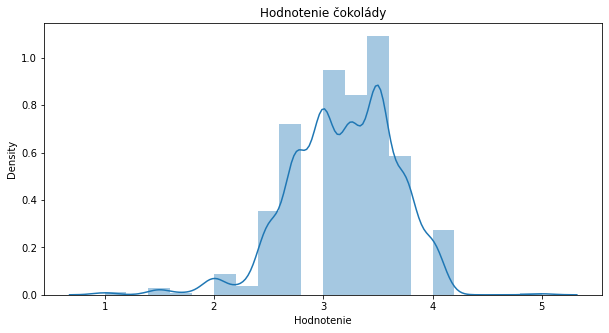

In [9]:
#Pre lepšiu vizualizáciu tých najzaujímavejších veličín z nášho datasetu, si vytvoríme niekoľko grafov.

#Vytvoríme si graf hodnotení čokolády
plt.figure(figsize=(10,5))
sns.distplot(data["Rating"], bins=20)
plt.xlabel("Hodnotenie")
plt.title("Hodnotenie čokolády")
plt.show()

#Ako môžeme vidieť, okolo 3.5/5 je najčastejšie hodnotenie čokoldáy 

In [10]:
#Následne aby sme vedeli lepšie pracovať so stĺpcom Počet percent kakaa,
#odstránime znamienko %  

data["CocoaPercent"] = data["CocoaPercent"].apply(lambda x: int(str(x)[:2]))
data["CocoaPercent"].value_counts()

# Ako môžeme vidieť, väčšina výrobcov čokolád v tomto datasete vyrábajú okolo 70% čokoládu.

#Taktiež jeden zo zaujímavých faktov je, že sú len 2 druhy čokolád, ktoré majú takmer 100% kakaových bôbov a to 99%

70    672
75    222
72    193
65     78
80     72
74     50
68     47
60     44
73     42
85     36
64     34
77     33
71     31
67     27
76     23
66     23
10     20
78     17
82     17
55     16
62     14
63     12
69     10
90      8
61      8
58      8
88      8
81      5
83      4
84      4
91      3
89      2
56      2
99      2
79      1
87      1
86      1
57      1
53      1
50      1
46      1
42      1
Name: CocoaPercent, dtype: int64

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


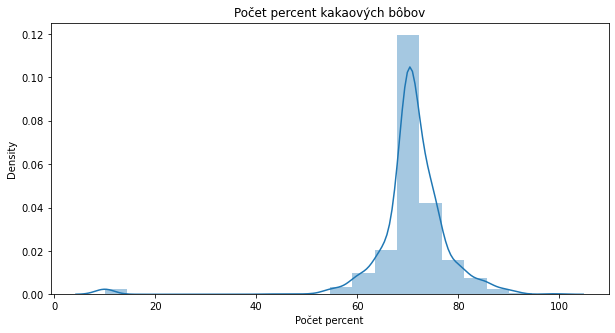

In [11]:
plt.figure(figsize=(10,5))

sns.distplot(data["CocoaPercent"], bins=20)

plt.xlabel("Počet percent")
plt.title("Počet percent kakaových bôbov")
plt.show()

In [12]:
#Pre zjednodušenie hodnotenia si zmeníme mierku hodnotenia od 0-5,
# Pre tento krok si vytvoríme funkciu
def change_rating(rating):
    if rating < 0.5: 
        return 0.0 
    elif rating < 1.5: 
        return 1.0 
    elif rating < 2.5: 
        return 2.0
    elif rating < 3.5: 
        return 3.0
    elif rating < 4.5: 
        return 4.0 
    elif rating < 5.5: 
        return 5.0

In [13]:
#Následne aplikujeme našu funkciu na všetky riadky v stĺpci Rating a využijeme na to lambda funkciu
data["Rating"] = data["Rating"].apply(lambda x: change_rating(x))

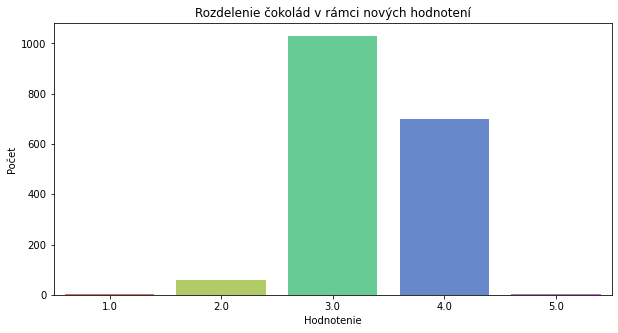

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x="Rating", data=data, palette='hls')
plt.xlabel("Hodnotenie")
plt.ylabel("Počet")
plt.title("Rozdelenie čokolád v rámci nových hodnotení")
plt.show()

#Môžeme vidieť, že naše hodnotenia sa zjednotili.

In [15]:
#Rozdelíme si dáta na 2 skupiny
# X- všetky parametre, ktoré ukazujú na rating čokolády
# y - rating čokolády

X = data.drop("Rating", axis=1)
y = data["Rating"].values
X

,Company,SpecificOrigin,REF,ReviewDate,CocoaPercent,Location,BeanType,BroadOrigin
0,A. Morin,Agua Grande,1876,2016,63,France,,Sao Tome
1,A. Morin,Kpime,1676,2015,70,France,,Togo
2,A. Morin,Atsane,1676,2015,70,France,,Togo
3,A. Morin,Akata,1680,2015,70,France,,Togo
4,A. Morin,Quilla,1704,2015,70,France,,Peru
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70,Austria,,Peru
1791,Zotter,Congo,749,2011,65,Austria,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65,Austria,Forastero,India
1793,Zotter,Kerala State,781,2011,62,Austria,,India


## 4. Rozdelenie dát, normalizácia dát a trénovanie modelu

In [16]:
# Následne si musíme rozdeliť dáta na trénovacie a testovacie
# trénovacími dátami budeme našu Neurónovú sieť trénovať  a testovacími dátami budeme testovať, našu natrénovanú sieť
# Vyberieme si 20% testovacích dát, čo znamená že z celého datasetu vyberieme 80% na trénovanie, teda učenie.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Company,SpecificOrigin,REF,ReviewDate,CocoaPercent,Location,BeanType,BroadOrigin
1023,Manoa,"Waiahole, O'ahu",1089,2013,72,U.S.A.,,Hawaii
1732,Wellington Chocolate Factory,Conacado,1756,2016,70,New Zealand,Trinitario,Dominican Republic
1555,Somerville,"Hawaiian, Big Island",1395,2014,70,U.S.A.,,Hawaii
1640,Tejas,Espada,967,2012,70,U.S.A.,,Brazil
175,Belyzium,Belize south,1768,2016,83,Germany,Trinitario,Belize
...,...,...,...,...,...,...,...,...
1130,Middlebury,Alto Beni,887,2012,75,U.S.A.,Criollo,Bolivia
1294,Pierre Marcolini,"Ocumare, Puerto Cabello, Venezuela",93,2006,72,Belgium,Criollo,Venezuela
860,Idilio (Felchlin),"Ocumare, H. Cata, 48hr c.",733,2011,72,Switzerland,Criollo,Venezuela
1459,Silvio Bessone,Maya Belize,717,2011,67,Italy,Criollo,Belize


In [17]:
# Pre lepšie spracovanie a učenie našej Neuronovej siete, musíme naše parametre pre rating zmeniť.

#One hot encoding je spôsob predspracovania kategorických funkcií pre modely strojového učenia. 
#Tento typ kódovania vytvorí novú binárnu funkciu pre každú možnú kategóriu a funkcii každej vzorky priradí 
#hodnotu 1, ktorá zodpovedá jej pôvodnej kategórii.

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X_train)
X_train_enc = ohe.transform(X_train)
X_test_enc = ohe.transform(X_test)
print(X_train_enc)

  (0, 223)	1.0
  (0, 1251)	1.0
  (0, 1491)	1.0
  (0, 1715)	1.0
  (0, 1740)	1.0
  (0, 1813)	1.0
  (0, 1852)	1.0
  (0, 1886)	1.0
  (1, 374)	1.0
  (1, 597)	1.0
  (1, 1658)	1.0
  (1, 1718)	1.0
  (1, 1738)	1.0
  (1, 1794)	1.0
  (1, 1845)	1.0
  (1, 1871)	1.0
  (2, 332)	1.0
  (2, 753)	1.0
  (2, 1568)	1.0
  (2, 1716)	1.0
  (2, 1738)	1.0
  (2, 1813)	1.0
  (2, 1852)	1.0
  (2, 1886)	1.0
  (3, 351)	1.0
  :	:
  (1432, 1933)	1.0
  (1433, 176)	1.0
  (1433, 989)	1.0
  (1433, 1401)	1.0
  (1433, 1713)	1.0
  (1433, 1740)	1.0
  (1433, 1811)	1.0
  (1433, 1824)	1.0
  (1433, 1933)	1.0
  (1434, 322)	1.0
  (1434, 920)	1.0
  (1434, 1397)	1.0
  (1434, 1713)	1.0
  (1434, 1735)	1.0
  (1434, 1788)	1.0
  (1434, 1824)	1.0
  (1434, 1854)	1.0
  (1435, 241)	1.0
  (1435, 914)	1.0
  (1435, 1604)	1.0
  (1435, 1717)	1.0
  (1435, 1738)	1.0
  (1435, 1813)	1.0
  (1435, 1852)	1.0
  (1435, 1898)	1.0


In [18]:
#label encoder je v podstate to isté, ako kód vyššie, avšak label encoder sa používa na y a nie X

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [19]:
#Zmeníme naše číselné hodnoty (0/1) - vektory,  na binárne classy

y_train_cat = keras.utils.to_categorical(y_train_enc)
y_test_cat = keras.utils.to_categorical(y_test_enc)

In [20]:
#StandardScaler odstráni priemer a upraví škály jednotlivých prvkov / premenných na rozptyly jednotiek. 
#Táto operácia sa vykonáva z hľadiska funkcií nezávislým spôsobom.
#StandardScaler môže byť ovplyvnený odľahlými hodnotami (ak existujú v množine údajov),
#pretože zahŕňa odhad empirického priemeru a štandardnej odchýlky každej vlastnosti.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
sc.fit(X_train_enc)
X_train_enc_sc = sc.transform(X_train_enc)
X_test_enc_sc = sc.transform(X_test_enc)

In [21]:
X_train_enc_sc.shape

(1436, 1943)

In [22]:
y_train_cat.shape

(1436, 5)

In [23]:
#Pri učení našej neuronovej sieti potrebujeme rozdeliť dáta, ktoré knižnica keras použije na trénovanie a validáciu.
#Aby sme si náš počet rozdelili rovnomerne, vypočítame si, koľko je 25% zo všetkých riadkov (359)

block = int(.25 * X_train_enc_sc.shape[0])
print(block)

#Vyberieme si dáta pre validáciu (359 riadkov) a pre parciálne trénovanie (359 - 1436 riadkov)
x_val = X_train_enc_sc[:block]
partial_x_train = X_train_enc_sc[block:]
y_val = y_train_cat[:block]
partial_y_train = y_train_cat[block:]

359


In [24]:
#Sekvenčný model umožňuje vytvárať modely krok za krokom po vrstvách.
#Keras Sequential je jeden z najjednoduchších modelov v knižnici, ale je tiež najobmedzenejší
#Pomocou Sekvenčného modelu môžeme riešiť problém len s jedným vstupom a s jedným výstupom s viacerými vrstvami
#Avšak my tento model použiť môžeme

model = tf.keras.models.Sequential()

#Náš model sa skladá z 1 vstupnej vrstvy, 2 skrytých vrstiev a 1 výstupnej vrstvy.

#Prvá skrytá vrstva sa skladá z:
# - 8 dimenzionálnych výstupov
# - aktivačnej funkcie "relu" (Usmernená lineárna aktivačná funkcia je po častiach lineárna funkcia, 
#   ktorá bude na výstup privádzať dáta priamo, ak je kladný vstup, v opačnom prípade bude na výstupe nula.)
# - input_dim = počet dimenzií (počet stĺpcov)
# - regularizer L2 funguje ako sila, ktorá odstraňuje malé percento váh pri každej iterácii. 
# - Preto sa váhy nikdy nebudú rovnať nule.

model.add(tf.keras.layers.Dense(8, activation='relu', input_dim=X_train_enc.shape[1], 
                       kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Druhá skrytá vrstva:
# - Dropout sa používa v našom prípade aby sa predošlo preťaženie modelu
#   Dropout náhodne nastaví výstupy skrytej vrstvy na 0 pri každej aktualizácii trénovacej fázy

model.add(tf.keras.layers.Dropout(0.5))

#Tretia skrytá vrstva:
# - 5 dimenzionálnych výstupov
# - používame aktivačnú funkciu softmax, ktorú použiváme ako normalizáciu výstupov a prevod z hodnôt 
#   váženého súčtu na pravdepodobnosti súčtu rovnej 1. Každá hodnota na výstupe funkcie softmax 
#   sa interpretuje ako pravdepodobnosť členstva pre každú triedu.
model.add(tf.keras.layers.Dense(5, activation='softmax'))


#Následne náš model kompilujeme, pretože trénovanie modelu, potrebuje optimzer a loss funkciu
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#Nakoniec náš model natrénujeme parciálnymi dátami X a y. 
history = model.fit(partial_x_train, partial_y_train, validation_data=(x_val, y_val),
                    batch_size=64, epochs=90, verbose=2)

Epoch 1/90
17/17 - 2s - loss: 1.7828 - accuracy: 0.2349 - val_loss: 1.5109 - val_accuracy: 0.3120
Epoch 2/90
17/17 - 0s - loss: 1.4722 - accuracy: 0.3751 - val_loss: 1.3735 - val_accuracy: 0.4373
Epoch 3/90
17/17 - 0s - loss: 1.3418 - accuracy: 0.4652 - val_loss: 1.2627 - val_accuracy: 0.4791
Epoch 4/90
17/17 - 0s - loss: 1.2097 - accuracy: 0.5218 - val_loss: 1.1650 - val_accuracy: 0.5487
Epoch 5/90
17/17 - 0s - loss: 1.1205 - accuracy: 0.5599 - val_loss: 1.0895 - val_accuracy: 0.5794
Epoch 6/90
17/17 - 0s - loss: 1.0463 - accuracy: 0.5896 - val_loss: 1.0259 - val_accuracy: 0.5933
Epoch 7/90
17/17 - 0s - loss: 0.9624 - accuracy: 0.6175 - val_loss: 0.9779 - val_accuracy: 0.5822
Epoch 8/90
17/17 - 0s - loss: 0.9010 - accuracy: 0.6332 - val_loss: 0.9348 - val_accuracy: 0.6045
Epoch 9/90
17/17 - 0s - loss: 0.8369 - accuracy: 0.6583 - val_loss: 0.9032 - val_accuracy: 0.5877
Epoch 10/90
17/17 - 0s - loss: 0.7602 - accuracy: 0.7122 - val_loss: 0.8793 - val_accuracy: 0.6045
Epoch 11/90
17/17 -

Epoch 84/90
17/17 - 0s - loss: 0.2203 - accuracy: 0.9099 - val_loss: 1.0463 - val_accuracy: 0.6240
Epoch 85/90
17/17 - 0s - loss: 0.2405 - accuracy: 0.9090 - val_loss: 1.0433 - val_accuracy: 0.6240
Epoch 86/90
17/17 - 0s - loss: 0.2381 - accuracy: 0.9136 - val_loss: 1.0279 - val_accuracy: 0.6295
Epoch 87/90
17/17 - 0s - loss: 0.2253 - accuracy: 0.9183 - val_loss: 1.0270 - val_accuracy: 0.6267
Epoch 88/90
17/17 - 0s - loss: 0.2376 - accuracy: 0.9155 - val_loss: 1.0403 - val_accuracy: 0.6295
Epoch 89/90
17/17 - 0s - loss: 0.2324 - accuracy: 0.9109 - val_loss: 1.0446 - val_accuracy: 0.6240
Epoch 90/90
17/17 - 0s - loss: 0.2375 - accuracy: 0.8979 - val_loss: 1.0568 - val_accuracy: 0.6295


## 5. Výsledky modelu 

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

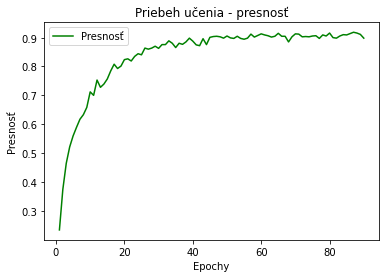

In [26]:
#Vykreslenie grafu, ktorý ukazuje na priebeh učenia pri presnosti. 
#Avšak táto hodnota, ktorá je v grafe je odlišná od skutočnosti, keďže náš model pri testovaej
#vzorke je okolo 65%
accuracy = history_dict["accuracy"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, color='g', label='Presnosť')
plt.title("Priebeh učenia - presnosť")
plt.xlabel("Epochy")
plt.ylabel("Presnosť")
plt.legend()
plt.show()

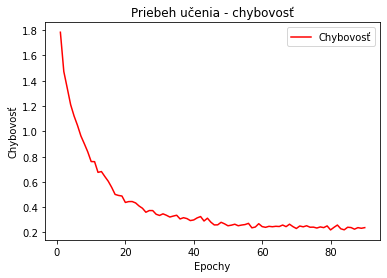

In [27]:
#Vykreslenie grafu, ktorý ukazuje na priebeh učenia pri presnosti. 
#Hodnota v grafe sa reálne približuje hodnote pri chybovosti testovacej vzorky.
loss = history_dict["loss"]

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, color='r', label='Chybovosť')
plt.title("Priebeh učenia - chybovosť")
plt.xlabel("Epochy")
plt.ylabel("Chybovosť")
plt.legend()
plt.show()

In [28]:
predict_train = model.predict(X_train_enc_sc)

score = model.evaluate(X_train_enc_sc, y_train_cat, verbose = 0)

print("Presnosť pri trénovaní: {}% \nChybovosť pri trénovaní: {}%".format(score[1]*100, (1 - score[1])*100))

Presnosť pri trénovaní: 90.11142253875732% 
Chybovosť pri trénovaní: 9.888577461242676%


In [29]:
pred_test = model.predict(X_test_enc_sc)

score = model.evaluate(X_test_enc_sc, y_test_cat, verbose = 0)

print("Presnosť pri testovaní: {}% \nChybovosť pri testovaní: {}%".format(score[1]*100, (1 - score[1])*100))

Presnosť pri testovaní: 66.29526615142822% 
Chybovosť pri testovaní: 33.70473384857178%
